In [1]:
import rospy
import actionlib
import actionlib.msg
import assignment_2_2023.msg
from std_srvs.srv import *
import sys
import select
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2023.msg import Vel
from assignment_2_2023.msg import PlanningAction, PlanningGoal, PlanningResult, PlanningActionResult
from actionlib_msgs.msg import GoalStatus
from sensor_msgs.msg import LaserScan
import math
import ipywidgets as widgets
from IPython.display import display 
from ipywidgets import Layout, HBox
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interactive, fixed
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



In [2]:
# Initialize global variables
past_goals = []
last_goal = None  # Keep track of the last goal

# keep track of reached/unreached goals
reached_goals = 0
unreached_goals = 0


# Define state descriptions
state_desc_ = {
    0: 'Go to point',
    1: 'Wall following',
    2: 'Done',
    6: 'Goal cancelled'
}

In [3]:
# Check if ROS node has already been initialized
if not rospy.core.is_initialized():
    rospy.init_node('set_target_client')

In [4]:
# Declare position_display in the global scope
position_display = widgets.HTML(value="<b>POSITION</b>: <b>x</b>: 0, <b>y</b>: 0<br><b>VELOCITY</b>: <b>linear</b>: 0, <b>angular</b>: 0}")

status_text = widgets.Label(value="Current Status: Unknown")

past_goals_label = widgets.HTML(value="<b>Past Goals:</b>")
past_goals_display = widgets.HTML()

reached_label = widgets.Label(value="Reached Goals: 0")
unreached_label = widgets.Label(value="Unreached Goals: 100")

In [5]:
# Publisher node function to handle position values and publish them
def publisher_node(msg):
    global pub, old_my_pos_and_vel
    
    # Get the actual position and velocity
    actual_pos = msg.pose.pose.position
    actual_vel_linear = msg.twist.twist.linear
    actual_vel_angular = msg.twist.twist.angular
    
    # Create a Vel message
    my_pos_and_vel = Vel()
    my_pos_and_vel.pos_x = actual_pos.x
    my_pos_and_vel.pos_y = actual_pos.y
    my_pos_and_vel.vel_x = actual_vel_linear.x
    my_pos_and_vel.vel_z = actual_vel_angular.z


    if (abs(my_pos_and_vel.pos_x - old_my_pos_and_vel.pos_x) > 0.05):
        old_my_pos_and_vel.pos_x = my_pos_and_vel.pos_x
    
    
    if (abs(my_pos_and_vel.pos_y -  old_my_pos_and_vel.pos_y) > 0.05):
        old_my_pos_and_vel.pos_y = my_pos_and_vel.pos_y

    if (abs(my_pos_and_vel.vel_x - old_my_pos_and_vel.vel_x) > 0.05):
        old_my_pos_and_vel.vel_x = my_pos_and_vel.vel_x

    if (abs(my_pos_and_vel.vel_z - old_my_pos_and_vel.vel_z) > 0.05):
        old_my_pos_and_vel.vel_z = my_pos_and_vel.vel_z
    
    # Publish the position and velocity
    pub.publish(my_pos_and_vel)

    new_pos_x = "{:.3f}".format(old_my_pos_and_vel.pos_x)
    new_pos_y = "{:.3f}".format(old_my_pos_and_vel.pos_y)
    new_vel_x = "{:.3f}".format(old_my_pos_and_vel.vel_x)
    new_vel_z = "{:.3f}".format(old_my_pos_and_vel.vel_z)    

    
    # Update position and velocity display
    position_display.value = f"<b>POSITION</b>: <b>x</b>: {new_pos_x}, <b>y</b>: {new_pos_y}<br><b>VELOCITY</b>: <b>linear</b>: {new_vel_x}, <b>angular</b>: {new_vel_z}"
    

In [6]:
global old_my_pos_and_vel
old_my_pos_and_vel = Vel()

old_my_pos_and_vel.pos_x = 0.0
old_my_pos_and_vel.pos_y = 0.0
old_my_pos_and_vel.vel_x = 0.0
old_my_pos_and_vel.vel_z = 0.0

# Initialize publisher
pub = rospy.Publisher('/pos_vel', Vel, queue_size=10)

# Initialize subscriber
sub_from_Odom = rospy.Subscriber("/odom", Odometry, publisher_node)

In [7]:
# Function to set goal
def set_goal(input_x, input_y):
    global past_goals, last_goal
    goal = PlanningGoal()
    rospy.set_param('/des_pos_x', input_x)
    rospy.set_param('/des_pos_y', input_y)
    goal.target_pose.pose.position.x = input_x
    goal.target_pose.pose.position.y = input_y
    
    # Check if the new goal is different from the last goal
    if last_goal is None or (input_x, input_y) != last_goal:
        past_goals.append((input_x, input_y))
        last_goal = (input_x, input_y)
        client.send_goal(goal)
        rospy.loginfo("Inserted goal: des_x = %f, des_y = %f", input_x, input_y)
        update_past_goals_display()  # Update past goals display after setting a new goal
    else:
        rospy.loginfo("New goal is the same as the previous one. Not setting it.")


In [8]:
def cancel_goal():
    if client.get_state() == actionlib.GoalStatus.ACTIVE:
        client.cancel_goal()
        rospy.loginfo("Goal cancelled")
    else:
        rospy.loginfo("No active goal to cancel")

In [10]:
# Update status_update function
def status_update(msg):
    global current_status, reached_goals, unreached_goals
    if msg.status_list:
        current_status = msg.status_list[0].status
        # print("Received current status:", current_status)
        if current_status in state_desc_:
            status_text.value = f"Current Status: {state_desc_[current_status]} ({current_status})"
        else:
            status_text.value = f"Current Status: Unknown ({current_status})"
        
        if current_status == GoalStatus.SUCCEEDED:
            reached_goals += 1
        elif current_status == GoalStatus.ABORTED or current_status == GoalStatus.REJECTED:
            unreached_goals += 1  
    else:
        status_text.value = "Current Status: Unknown"

In [9]:
client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
client.wait_for_server()

True

In [11]:
# Create widgets for setting goal
goal_x = widgets.FloatSlider(min=-15.0, max=15.0, step=0.1, description='desired x:')
goal_y = widgets.FloatSlider(min=-15.0, max=15.0, step=0.1, description='desired y:')
set_goal_button = widgets.Button(description="Set Goal")
cancel_goal_button = widgets.Button(description="Cancel Goal")

In [12]:
# Define actions for button clicks
def set_goal_click(b):
    set_goal(goal_x.value, goal_y.value)

def cancel_goal_click(b):
    cancel_goal()

In [13]:
# Assign actions to buttons
set_goal_button.on_click(set_goal_click)
cancel_goal_button.on_click(cancel_goal_click)

In [14]:
# Subscribe to goal status updates
goal_status_sub = rospy.Subscriber('/reaching_goal/status', GoalStatus, status_update)

In [15]:
# Update past goals display
def update_past_goals_display():
    global past_goals_display
    goals_str = "<ul>"
    for goal in past_goals:
        goals_str += f"<li>X: {goal[0]}, Y: {goal[1]}</li>"
    goals_str += "</ul>"
    past_goals_display.value = goals_str

In [16]:
# Call update function initially
update_past_goals_display()

In [17]:
# Create widgets for displaying reached and unreached goals
reached_label = widgets.Label(value=f'Reached Goals: {reached_goals}')
unreached_label = widgets.Label(value=f'Unreached Goals: {unreached_goals}')

In [18]:
# Style widgets 
goal_x.layout.width = '400px'
goal_y.layout.width = '400px'
set_goal_button.style.button_color = 'lightblue'
cancel_goal_button.style.button_color = 'lightcoral'
status_text.layout.margin = '20px 0'
position_display.layout.margin = '20px 0'
past_goals_display.layout.max_width = '400px'

# Arrange widgets
goal_setting_widgets = widgets.VBox([goal_x, goal_y, HBox([set_goal_button, cancel_goal_button], layout=Layout(justify_content='center'))])
status_widgets = widgets.VBox([status_text, position_display], layout=Layout(justify_content='center'))
central_column = widgets.VBox([goal_setting_widgets, status_widgets, past_goals_display], layout=Layout(justify_content='center', align_items='center'))

# Display widgets
# display(widgets.HBox([central_column, plot_widget]))
display(widgets.HBox([central_column]))



## PLOT POSIZIONI

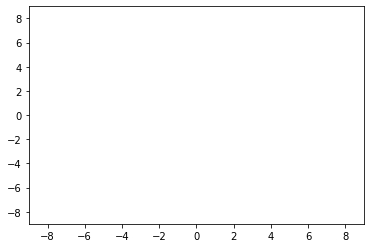

In [19]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(-9,9)
    ax.set_ylim(-9,9)
    return ln,

def update(frame):
    global old_my_pos_and_vel
    print_pos_x = old_my_pos_and_vel.pos_x
    print_pos_y = old_my_pos_and_vel.pos_y

    xdata.append(print_pos_x)
    ydata.append(print_pos_y)

    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, init_func=init, blit=True)
#plt.show()

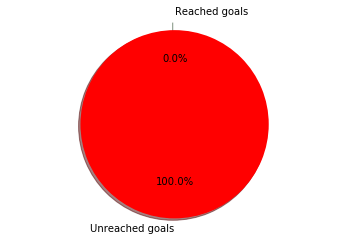

In [20]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Reached goals', 'Unreached goals'

if (reached_goals == 0 and unreached_goals == 0):
    sizes = [ 0, 100]
else: 
    sizes = [reached_goals, unreached_goals]
    
colors = ['green', 'red']
explode = (0, 0.1) # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
shadow=True, startangle=90)
ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
